<a href="https://colab.research.google.com/github/TIANBOQIU/AppliedDeepLearning/blob/master/ReinforcementLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# MIT Deep Learning Project
# Model-Free Reinforcement Learning
# focus on building a model-free reinforcement learning algorithm to
# master two differnet environments with varying caomplexity
# 1. Cartpole   2. Pong

#Cartpole

In [0]:
# First, we'll need to create our environment and initialize our agent
# Moreover, we'll need to provide our agent some sort of mechanism for 
# remembering action and reward history
# Then we'll need to define our learning algorithm

In [0]:
# import tensorflow, enable Eager execution, and also import some dependencies
# to make apt-get install less noisy
# redirect all the stdout into nothingness
# still show stderr in the console (redirect stderr to stdout)
! apt-get install -y xvfb python-opengl > /dev/null 2>&1
! pip install gym pyvirtualdisplay scikit-video > /dev/null 2>&1

import tensorflow as tf
tf.enable_eager_execution()
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
import time

# Download the class repository
! git clone https://github.com/aamini/introtodeeplearning_labs.git  > /dev/null 2>&1
% cd introtodeeplearning_labs
! git pull
% cd ..

import introtodeeplearning_labs as util


/content/introtodeeplearning_labs
Already up to date.
/content


In [0]:
print(tf.__version__)

1.13.1


In [0]:
# set a random seed to ensure some level of reproducibility
env = gym.make('CartPole-v0')
env.seed(1)

[1L]

In [0]:
# CartPole Environment
# the system is controlled by applying a force of +1 or -1 to the cart
# pendulum starts upright, and the goal is to prevent it from falling over
# a reward +1 is provided for every timestep that the pole remains upright
# the episode ends when the pole is more than 15 degrees from vertical,
# or the cart moves more than 2.4 units from the center

In [0]:
# Observation
# position of cart
# velocity of cart
# angle of pole
# rotation rate of pole

In [0]:
print('Environment has observation space = {}'.format(env.observation_space))

Environment has observation space = Box(4,)


In [0]:
#At every time step, the agent can move either right or left
n_actions = env.action_space.n
print('Number of possible actions that the agent can choose from = {}'.format(env.action_space.n))

Number of possible actions that the agent can choose from = 2


In [0]:
# Define the Agent
# simply a deep neural network which takes as input an observation
# of the environment and outputs the probability of taking each of the 
# possible actions
# Perform Policy Learning 

def create_cartpole_model():
  model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(units=32, activation='relu'),
      tf.keras.layers.Dense(units=n_actions, activation=None)
  ])
  
  return model

cartpole_model = create_cartpole_model()

def choose_action(model, observation):
  # reshape observation into a row vector, -1 means to infer that dimension
  observation = observation.reshape([1,-1])
  logits = model.predict(observation)
  prob_weights = tf.nn.softmax(logits).numpy()
  # sample from the prob_weights to pick an action
  # np.random.choice returns a list like array([1]) 
  action = np.random.choice(n_actions, size=1, p=prob_weights.flatten())[0]
  return action

# create the agent's memory
# During training, the agent will need to remember all of its
# observations, actions so that once the episode end, it can
# 'reinforce' the good actions and punish the undesirable actions
# memory buffer: agent's observations, actions, and received reward
# from a given episode

class Memory:
  def __init__(self):
    self.clear()
   
  def clear(self):
    self.observations = []
    self.actions = []
    self.rewards = []
   
  def add_to_memory(self, new_observation, new_action, new_reward):
    self.observations.append(new_observation)
    self.actions.append(new_action)
    self.rewards.append(new_reward)

memory = Memory()

In [0]:
def normalize(x):
  x -= np.mean(x)
  x /= np.std(x)
  return x

def discount_rewards(rewards, gamma=0.95):
  discounted_rewards = np.zeros_like(rewards)
  R = 0
  for t in reversed(range(0, len(rewards))):
    R = R * gamma + rewards[t]
    discounted_rewards[t] = R
  
  return normalize(discounted_rewards)

In [0]:
# Define the learning algorithm
# start by defining the optimizer we want to use
learning_rate = 1e-3
optimizer = tf.train.AdamOptimizer(learning_rate)

def compute_loss(logits, actions, rewards):
  neg_logprob = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=actions)
  loss = tf.reduce_mean(neg_logprob * rewards)
  return loss
  

In [0]:
def train_step(model, optimizer, observations, actions, discounted_rewards):
  with tf.GradientTape() as tape:
    observations = tf.convert_to_tensor(observations, dtype=tf.float32)
    logits = model(observations)
    loss = compute_loss(logits, actions, discounted_rewards)
  
  grads = tape.gradient(loss, model.variables)
  optimizer.apply_gradients(zip(grads, model.variables), global_step=tf.train.get_or_create_global_step())
  

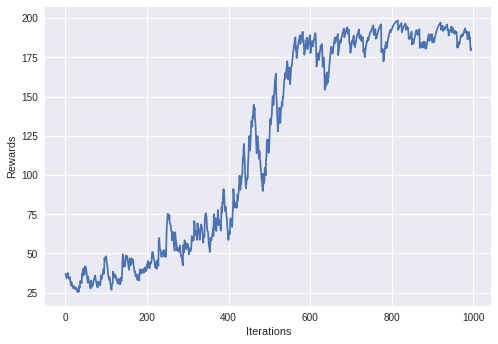

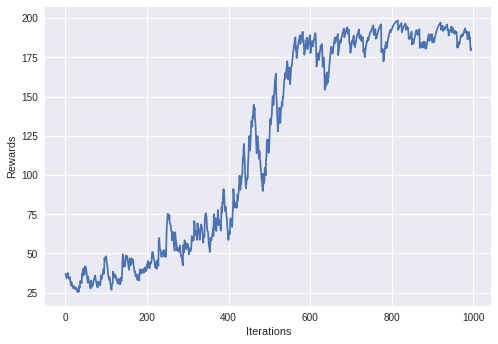

In [0]:
cartpole_model = create_cartpole_model()

smoothed_reward = util.LossHistory(smoothing_factor=0.9)
plotter = util.PeriodicPlotter(sec=5, xlabel='Iterations', ylabel='Rewards')

for i_episode in range(1000):
  plotter.plot(smoothed_reward.get())
  
  observation = env.reset()
  
  while True:
    action = choose_action(cartpole_model, observation)
    next_observation, reward, done, info = env.step(action)
    memory.add_to_memory(observation, action, reward)
    
    if done:
      total_reward = sum(memory.rewards)
      smoothed_reward.append(total_reward)
      train_step(cartpole_model,
                 optimizer,
                 observations = np.vstack(memory.observations),
                 actions = np.array(memory.actions),
                 discounted_rewards = discount_rewards(memory.rewards)
                )
      memory.clear()
      break
    observation = next_observation

In [0]:
def save_video_of_model(model, env_name, filename='agent.mp4'):  
  import skvideo.io
  from pyvirtualdisplay import Display
  display = Display(visible=0, size=(40, 30))
  display.start()

  env = gym.make(env_name)
  obs = env.reset()
  shape = env.render(mode='rgb_array').shape[0:2]

  out = skvideo.io.FFmpegWriter(filename)

  done = False
  while not done: 
      frame = env.render(mode='rgb_array')
      out.writeFrame(frame)
      
      action = model(tf.convert_to_tensor(obs.reshape((1,-1)), tf.float32)).numpy().argmax()
      obs, reward, done, info = env.step(action)
  out.close()
  print "Successfully saved into {}!".format(filename)

save_video_of_model(cartpole_model, "CartPole-v0")

Successfully saved into agent.mp4!


In [0]:
!ls

introtodeeplearning_labs  sample_data


In [0]:
from IPython.display import HTML
import io, base64
video = io.open('./agent.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
<video controls>
  <source src='data:video/mp4;base64,{0}' type='video/mp4' />
</video>
'''.format(encoded.decode('ascii')))